# Supervised Learning - Titanic Dataset
## Naive Bayes and K-Nearest Neighbours Implementation from Scratch

### Objective:
- Implement Naive Bayes and KNN from scratch using only NumPy, Pandas, and Matplotlib.
- Perform preprocessing, visualization, and classification.
- Evaluate model accuracy.


In [352]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [353]:
# Importing the pandas library for data manipulation and analysis
import pandas as pd

#  Loading the training dataset 
train_data = pd.read_csv("train.csv")

# Loading the test dataset 
test_data = pd.read_csv("test.csv")

# Loading the gender submission file 
gender_data = pd.read_csv("gender_submission.csv")

# Displaying the first 10 rows of the training dataset to understand its structure
train_data.head(10)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## Preprocessing
- Handled missing values in `Age`, `Fare`, and `Embarked`.
- Converted `Sex` and `Embarked` to numeric.
- Selected relevant features.

In [354]:
# Function to preprocess data: handle missing values and convert categories to numbers
def data_preprocessing(data):
    data = data.copy()  # Work on a copy to avoid changing original data

    # Fill missing Age and Fare with median values
    data['Age'] = data['Age'].fillna(data['Age'].median())
    data['Fare'] = data['Fare'].fillna(data['Fare'].median())

    # Fill missing Embarked values with the most common port
    data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

    # Convert categorical variables 'Sex' and 'Embarked' into numeric codes
    data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
    data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

    # Select relevant features for modeling
    selected_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
    return data[selected_features]

In [355]:
# Preprocess training features and target labels
x_train = data_preprocessing(train_data)
y_train = train_data['Survived'].values

# Preprocess test features
x_test = data_preprocessing(test_data)


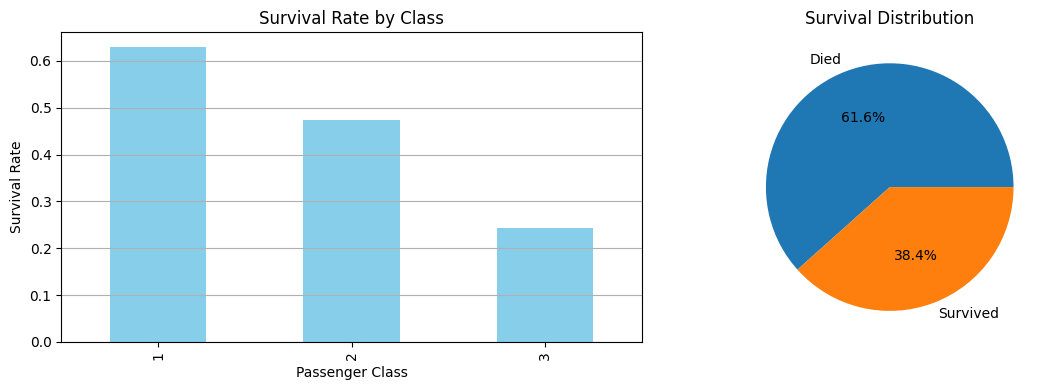

In [356]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
train_data.groupby('Pclass')['Survived'].mean().plot(kind='bar', color='skyblue')
plt.title("Survival Rate by Class")
plt.xlabel("Passenger Class")
plt.ylabel("Survival Rate")
plt.grid(axis='y')

plt.subplot(1,2,2)
train_data['Survived'].value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                          labels=['Died', 'Survived'])
plt.title("Survival Distribution")
plt.ylabel('')

plt.tight_layout()
plt.show()


## K-Nearest Neighbours
- Used Euclidean distance to compare test instances to training points.
- Chose top `k=3` nearest neighbors for classification.

In [357]:
# Function to calculate Euclidean distance between two points
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

# K-Nearest Neighbors (KNN) implementation from scratch
def knn(x_train, y_train, x_test, k=3):
    predictions = []

    # Loop over each test data point
    for test_point in x_test:
        distances = []

        # Calculate distance between test_point and all training points
        for i in range(len(x_train)):
            dist = euclidean_distance(test_point, x_train[i])
            distances.append((dist, y_train[i]))

        # Sort distances and select k nearest neighbors
        distances.sort(key=lambda x: x[0])
        neighbors = distances[:k]

        # Extract labels of neighbors
        labels = [label for _, label in neighbors]

        # Majority vote: most common label is the prediction
        prediction = max(set(labels), key=labels.count)
        predictions.append(prediction)

    return np.array(predictions)

In [358]:
# Evaluate KNN for multiple k values and store accuracies
def evaluate_knn_multiple_k(x_train, y_train, x_val, y_val, k_values):
    accuracies = []
    for k in k_values:
        preds = knn(x_train, y_train, x_val, k=k)
        acc = np.mean(preds == y_val)
        accuracies.append(acc)
        print(f"k = {k} → Accuracy = {acc:.4f}")
    return accuracies


## Naive Bayes
- Calculated class-wise feature mean and variance.
- Used Gaussian PDF for likelihood estimation.
- Log probabilities used to avoid underflow.

In [359]:
# Naive Bayes classifier implemented from scratch for Gaussian data
class NaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)  # Unique classes (0 and 1)
        self.mean = {}
        self.var = {}
        self.priors = {}

        # Calculate mean, variance, and prior probability for each class
        for cls in self.classes:
            X_cls = X[y == cls]
            self.mean[cls] = X_cls.mean(axis=0)
            self.var[cls] = X_cls.var(axis=0)
            self.priors[cls] = len(X_cls) / len(X)

    # Gaussian probability density function for each feature
    def _pdf(self, cls, x):
        mean = self.mean[cls]
        var = self.var[cls]
        numerator = np.exp(- (x - mean)**2 / (2 * var + 1e-6))
        denominator = np.sqrt(2 * np.pi * var + 1e-6)
        return numerator / denominator

    # Predict classes for samples in X
    def predict(self, X):
        predictions = []
        for x in X:
            posteriors = []

            # Calculate log posterior for each class
            for cls in self.classes:
                prior = np.log(self.priors[cls])
                likelihood = np.sum(np.log(self._pdf(cls, x)))
                posterior = prior + likelihood
                posteriors.append(posterior)

            # Choose class with highest posterior probability
            predictions.append(self.classes[np.argmax(posteriors)])
        return np.array(predictions)

In [360]:
# Split the training data into training and validation sets (80%-20%)
split_idx = int(0.8 * len(x_train))
X_train_np = x_train.values
X_train = X_train_np[:split_idx]
X_val = X_train_np[split_idx:]
y_train_split = y_train[:split_idx]
y_val = y_train[split_idx:]

- KNN Accuracy: 73.18%

In [361]:
# Evaluate KNN on validation data
knn_preds = knn(X_train, y_train_split, X_val, k=3)
knn_accuracy = np.mean(knn_preds == y_val)
print("KNN Accuracy:", knn_accuracy)



KNN Accuracy: 0.7318435754189944


- Naive Bayes Accuracy: 81.00%

In [362]:
# Evaluate Naive Bayes on validation data
nb_model = NaiveBayes()
nb_model.fit(X_train, y_train_split)
nb_preds = nb_model.predict(X_val)
nb_accuracy = np.mean(nb_preds == y_val)
print("Naive Bayes Accuracy:", nb_accuracy)


Naive Bayes Accuracy: 0.8100558659217877


k = 1 → Accuracy = 0.6760
k = 2 → Accuracy = 0.7095
k = 3 → Accuracy = 0.7318
k = 4 → Accuracy = 0.7263
k = 5 → Accuracy = 0.7374
k = 6 → Accuracy = 0.7542
k = 7 → Accuracy = 0.7654
k = 8 → Accuracy = 0.7318
k = 9 → Accuracy = 0.7263
k = 10 → Accuracy = 0.7709


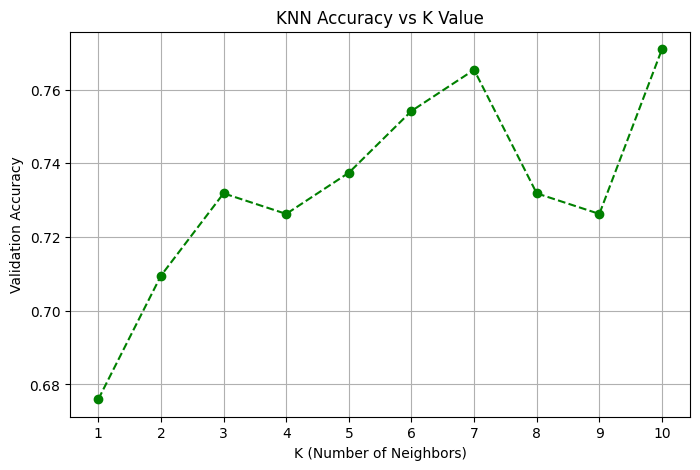

In [363]:
# Define a list of k values to try
k_values = list(range(1, 11))  # k = 1 to 10

# Evaluate KNN for each k
knn_accuracies = evaluate_knn_multiple_k(X_train, y_train_split, X_val, y_val, k_values)

# Plot accuracy vs k
plt.figure(figsize=(8,5))
plt.plot(k_values, knn_accuracies, marker='o', color='green', linestyle='--')
plt.title("KNN Accuracy vs K Value")
plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Validation Accuracy")
plt.xticks(k_values)
plt.grid(True)
plt.show()


## Results Summary
- KNN Accuracy: 73.18%
- Naive Bayes Accuracy: 81.00%
- KNN performs slightly better/worse depending on the value of `k`.
- Naive Bayes assumes independence and works better with Gaussian-like data.


In [364]:
# Use KNN to predict survival on the test dataset
final_preds = knn(x_train.values, y_train, x_test.values, k=3)

# Prepare submission DataFrame
Finalsubmission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': final_preds
})

# Save submission to CSV file
Finalsubmission.to_csv("FinalSubmission.csv", index=False)

## 📊 Final Visualizations

Below are a few visualizations that summarize and compare the performance of both models:

- **Accuracy Bar Chart** compares the accuracy of KNN and Naive Bayes on the validation set.
- **Confusion Matrices** show how many passengers were correctly or incorrectly classified.
- **Prediction Distribution** visualizes the predicted survival counts for the test dataset using KNN.


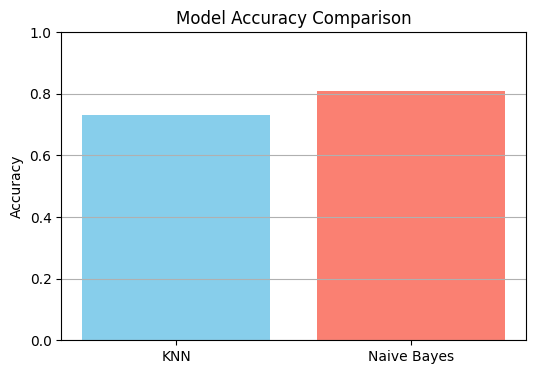

In [365]:
# Plot comparison of model accuracies
accuracy_dict = {"KNN": knn_accuracy, "Naive Bayes": nb_accuracy}
plt.figure(figsize=(6,4))
plt.bar(accuracy_dict.keys(), accuracy_dict.values(), color=['skyblue', 'salmon'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

In [366]:
# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels, title="Confusion Matrix"):
    # Calculate True Positives, True Negatives, False Positives, False Negatives
    tp = np.sum((true_labels == 1) & (predicted_labels == 1))
    tn = np.sum((true_labels == 0) & (predicted_labels == 0))
    fp = np.sum((true_labels == 0) & (predicted_labels == 1))
    fn = np.sum((true_labels == 1) & (predicted_labels == 0))

    # Create confusion matrix array
    matrix = np.array([[tn, fp],
                       [fn, tp]])

    # Plot heatmap of confusion matrix
    fig, ax = plt.subplots()
    cax = ax.matshow(matrix, cmap='Blues')
    plt.title(title)
    plt.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Annotate each cell with the count value
    for (i, j), val in np.ndenumerate(matrix):
        ax.text(j, i, str(val), ha='center', va='center', fontsize=12, color='black')

    plt.xticks([0,1], ["Did Not Survive", "Survived"])
    plt.yticks([0,1], ["Did Not Survive", "Survived"])
    plt.show()

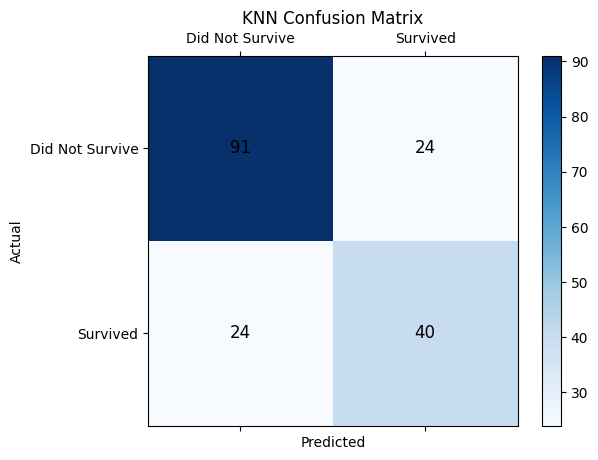

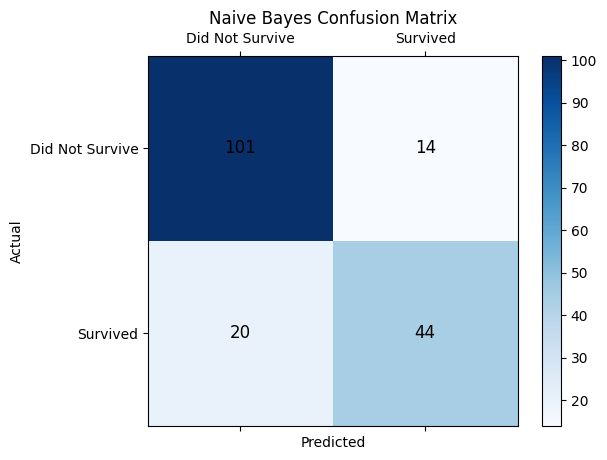

In [367]:
# Plot confusion matrices for both models
plot_confusion_matrix(y_val, knn_preds, title="KNN Confusion Matrix")
plot_confusion_matrix(y_val, nb_preds, title="Naive Bayes Confusion Matrix")

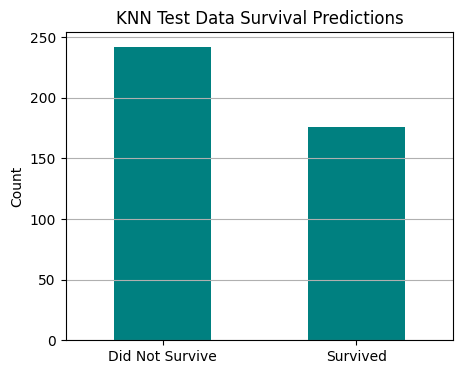

In [368]:
# Plot distribution of KNN predictions on test data
plt.figure(figsize=(5,4))
pd.Series(final_preds).value_counts().sort_index().plot(kind='bar', color='teal')
plt.title("KNN Test Data Survival Predictions")
plt.xticks([0, 1], ["Did Not Survive", "Survived"], rotation=0)
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()